# Fermat LEUKAM

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import linalg

In [75]:
df_ratings=pd.read_csv('/home/fermat/Desktop/ml-25m-20240518T135232Z-001/ml-25m/ml-25m/ratings.csv')

In [76]:
df_movies=pd.read_csv('/home/fermat/Desktop/ml-25m-20240518T135232Z-001/ml-25m/ml-25m/movies.csv')
print(df_movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [77]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
df=pd.merge(df_ratings,df_movies, how='left',on='movieId')
df.head()

In [ ]:
df2=df.groupby('title')[['rating']].count()
rating_count_20=df2.nlargest(10,'rating')
rating_count_20.head()

In [ ]:
plt.figure(figsize=(30,10))
plt.title('Top 20 movies with highest number of ratings',fontsize=30)
plt.xticks(fontsize=25,rotation=90)
plt.yticks(fontsize=25)
plt.xlabel('movies title',fontsize=30)
plt.ylabel('ratings',fontsize=30)

plt.bar(rating_count_20.index,rating_count_20.rating,color='skyblue')

filename = 'Top 20 movies with highest number of ratings.pdf'
plt.savefig(filename,bbox_inches='tight')

 # %download_file rating_Distribution.pdf
plt.savefig('Top 20 movies with highest number of ratings.pdf',format='pdf')
plt.show()

In [ ]:
# Retrieve the values of the 'rating' variable
rating_values = df_ratings['rating']

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(rating_values, bins=10, color='skyblue', edgecolor='black')  # Plot the histogram
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.grid(True)

plt.savefig('rating_Distribution.pdf',format='pdf')
plt.show()

In [ ]:
from collections import Counter

# Calculate the distribution of userId and movieId using Counter
userId_distri = Counter(df_ratings['userId'])

# Extract the values and normalized frequencies
my_list_1 = []
for i in sorted(userId_distri):
    my_list_1.append(userId_distri[i])

# Count the occurrences of each value in the list
occurrences_1 = Counter(my_list_1)

# Extract the unique values and frequencies
x_userId = list(occurrences_1.keys())
y_userId = list(occurrences_1.values())

# Plot the distribution on a logarithmic scale
plt.figure(figsize=(10, 7))

# For userId
plt.plot(x_userId, y_userId,'bo', label='userId')

plt.title('powerlaw of User')
plt.xlabel('degree', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale('log')
plt.xscale('log')
plt.legend()


plt.savefig('User_powerlaw.pdf',format='pdf')
plt.show()

In [ ]:
movieId_distri = Counter(df_ratings['movieId'])

# Extract the values and normalized frequencies
my_list_2 = []
for i in sorted(movieId_distri):
    my_list_2.append(userId_distri[i])

# Count the occurrences of each value in the list
occurrences_2 = Counter(my_list_2)

# Extract the unique values and frequencies
x_movieId = list(occurrences_2.keys())
y_movieId = list(occurrences_2.values())

# Plot the distribution on a logarithmic scale
plt.figure(figsize=(10, 7))

# For movieId
plt.plot(x_movieId, y_movieId, 'ro', label='movieId')

plt.title('powerlaw of movie')
plt.xlabel('degree', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale('log')
plt.xscale('log')
plt.legend()

plt.savefig('Movie_powerlaw.pdf',format='pdf')
plt.show()

In [78]:
user_data_column = df_ratings['userId'].to_numpy(dtype = int)
movie_data_column = df_ratings['movieId'].to_numpy(dtype= int)
rating_data_column= df_ratings['rating'].to_numpy(dtype=float)

# indexing of data

In [79]:
# mapping
movie_to_id = {}
user_to_id = {}
id_to_user = []
id_to_movie = []

# sparse matrices
data_by_user = []
data_by_movie = []

for (user_index, movie_index, rating) in zip(user_data_column,
                                             movie_data_column,
                                             rating_data_column):

  if user_index not in user_to_id:
    m = len(id_to_user)
    user_to_id[user_index] = m
    id_to_user.append(user_index)
    data_by_user.append([])
  else:
    m = user_to_id[user_index]

  if movie_index not in movie_to_id:
    n = len(id_to_movie)
    movie_to_id[movie_index] = n
    id_to_movie.append(movie_index)
    data_by_movie.append([])
  else:
    n = movie_to_id[movie_index]

    data_by_user[m].append((n, rating))
    data_by_movie[n].append((m, rating))


#  biases only

In [80]:
M = len(data_by_user)
N = len(data_by_movie)
user_biases = np.zeros(M)
item_biases = np.zeros(N)

# Initialize user and item factors

lambda_ = 0.01
gamma = 0.5
tau = 0.4
# Initialize lists to store loss and RMSE  for each iteration
losses_1 = []
rmses_1 = []

# Stopping condition
num_iterations = 20

def get_items_and_ratings_for_user(data_by_user, user_id):
    return data_by_user[user_id]
for iter in tqdm(range(num_iterations)):
    # Update user biases
    for m in range(M):
        bias = 0
        item_counter = 0
        for (n, r) in data_by_user[m]:
            bias += r - item_biases[n] 
            item_counter += 1
        user_biases[m] = lambda_ *bias / (lambda_ * item_counter + gamma)

    # Update item biases
    for n in range(N):
        bias = 0
        user_counter = 0
        for (m, r) in data_by_movie[n]:
            bias +=  r - user_biases[m] 
            user_counter += 1
        item_biases[n] = lambda_ *bias / (lambda_ * user_counter + gamma)


    # Calculate loss and RMSE for training
    loss_1 = 0
    total_ratings = 0
    for m in range(M):
        for (n, r) in get_items_and_ratings_for_user(data_by_user,m):
            pred = user_biases[m] + item_biases[n] 
            loss_1 += (r - pred) ** 2
            total_ratings += 1
    # Add regularization terms to the loss
    regularization =  (gamma/2)*(np.sum(item_biases**2) + np.sum(user_biases**2))
    rmse_1 = np.sqrt(loss_1/total_ratings)
    rmses_1.append(rmse_1)
    loss_1 = -(lambda_ / 2) * loss_1 - regularization
    losses_1.append(-loss_1)

100%|███████████████████████████████████████████| 20/20 [05:51<00:00, 17.58s/it]


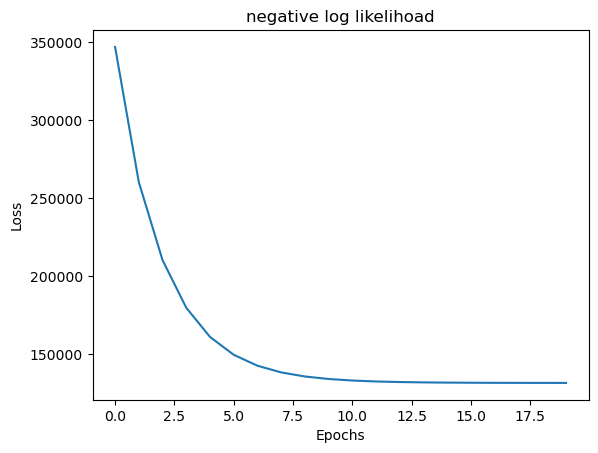

In [81]:
plt.plot(range(num_iterations), losses_1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('negative log likelihoad')
plt.savefig('frist loss.pdf',format='pdf')
plt.show()

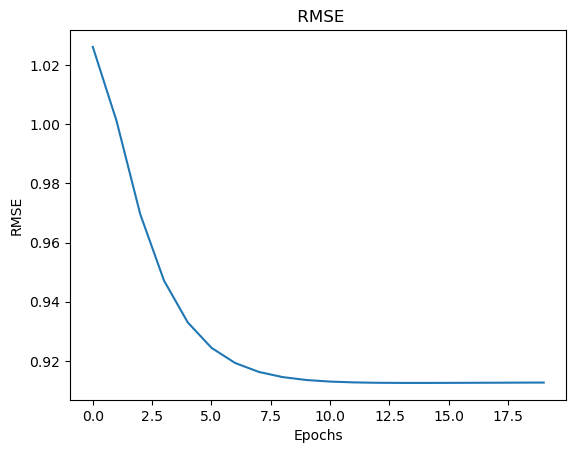

In [82]:
plt.plot(range(num_iterations),rmses_1)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title(' RMSE')
plt.savefig('frist RMSE.pdf',format='pdf')
plt.show()

# Training the model containing the user vector and the item vector over the entire dataset with k=10.

In [105]:
M = len(data_by_user)
N = len(data_by_movie)
user_biases_model = np.zeros(M)
item_biases_model = np.zeros(N)

# Initialize user and item factors
K = 10 # Number of latent factors
U_model = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
V_model = np.random.normal(0, 1/np.sqrt(K), size=(N,K))

# Hyperparameters
lambda_ = 0.01
gamma = 0.5
tau = 0.4
# Initialize lists to store loss and RMSE  for each iteration
losses_2 = []
rmses_2= []

# Stopping condition
num_iterations = 20


# Define a function to get items and ratings for a user
def get_items_and_ratings_for_user(data_by_user, user_id):
    return data_by_user[user_id]
for iter in tqdm(range(num_iterations)):
    # Update user biases
    for m in range(M):
        bias = 0
        item_counter = 0
        for (n, r) in data_by_user[m]:
            bias += r - item_biases_model[n] - np.dot(U_model[m].T, V_model[n])
            item_counter += 1
        user_biases_model[m] = lambda_ *bias / (lambda_ * item_counter + gamma)

    # Update item biases
    for n in range(N):
        bias = 0
        user_counter = 0
        for (m, r) in data_by_movie[n]:
            bias +=  r - user_biases_model[m] - np.dot(U_model[m].T,V_model[n])
            user_counter += 1
        item_biases_model[n] = lambda_ *bias / (lambda_ * user_counter + gamma)

    # Update user factors
    for m in range(M):
        t0 = np.zeros((K,K))
        t1= np.zeros(K)
        for (n, r) in data_by_user[m]:
            prediction = user_biases_model[m] + item_biases_model[n]
            error = r - prediction
            t1 += V_model[n]*error
            t0 += np.dot(V_model[n].reshape(-1,1), V_model[n].reshape(-1,1).T)
        t0 = lambda_*t0 + tau*np.eye(K)
        t1 = lambda_*t1
        U_model[m] = linalg.solve(t0,t1)

    # Update item factors
    for n in range(N):
        t2 = np.zeros((K,K))
        t3= np.zeros(K)
        # for (n, r) in get_items_and_ratings_for_user(m):
        for (m, r) in data_by_movie[n]:
            prediction = user_biases_model[m] + item_biases_model[n]
            error = r - prediction
            t3 += U_model[m]*error
            t2 += np.dot(U_model[m].reshape(-1,1), U_model[m].reshape(-1,1).T)
        t2 = lambda_*t2 + tau*np.eye(K)
        t3 = lambda_*t3
        V_model[n] = linalg.solve(t2,t3)

    # Calculate loss and RMSE for training
    loss_2 = 0
    total_ratings = 0
    for m in range(M):
        for (n, r) in get_items_and_ratings_for_user(data_by_user,m):
            pred = user_biases_model[m] + item_biases_model[n] + np.dot(U_model[m].T, V_model[n])
            loss_2 += (r - pred) ** 2
            total_ratings += 1
    # Add regularization terms to the loss
    regularization = (tau / 2) * (np.sum(U_model**2) + np.sum(V_model**2)) + (gamma/2)*(np.sum(item_biases_model**2)+np.sum(user_biases_model**2))
    rmse_2 = np.sqrt(loss_2/total_ratings)
    rmses_2.append(rmse_2)
    loss_2 = -(lambda_ / 2) * loss_training - regularization
    losses_2.append(-loss_2)

100%|████████████████████████████████████████| 20/20 [1:03:39<00:00, 190.98s/it]


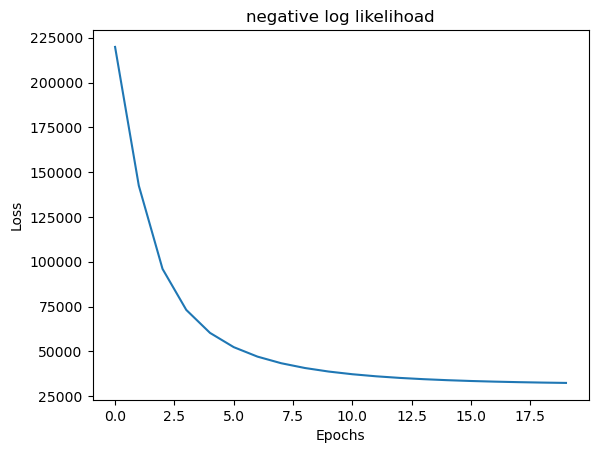

In [106]:
plt.plot(range(num_iterations), losses_2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('negative log likelihoad')
plt.savefig('second loss.pdf',format='pdf')
plt.show()

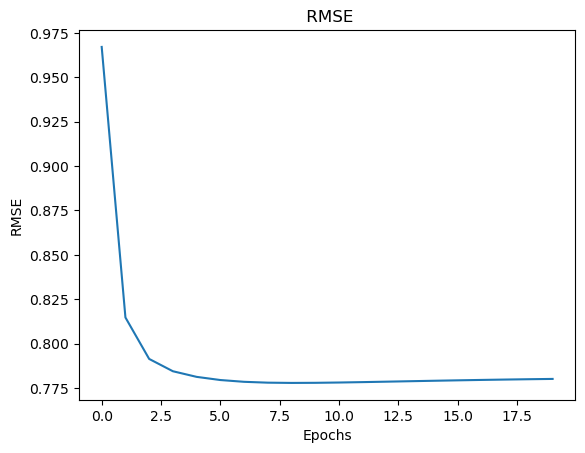

In [107]:
plt.plot(range(num_iterations),rmses_2)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title(' RMSE')
plt.savefig('second RMSE.pdf',format='pdf')
plt.show()

# data separation in train and test set.

In [10]:
# mapping
movie_to_id = {}
user_to_id = {}
id_to_user = []
id_to_movie = []

# sparse matrices
data_by_user_train = []
data_by_user_test = []
data_by_movie_train = []
data_by_movie_test = []

for (user_index, movie_index, rating) in zip(user_data_column,
                                             movie_data_column,
                                             rating_data_column):

  if user_index not in user_to_id:
    m = len(id_to_user)
    user_to_id[user_index] = m
    id_to_user.append(user_index)
    data_by_user_train.append([])
    data_by_user_test.append([])
  else:
    m = user_to_id[user_index]

  if movie_index not in movie_to_id:
    n = len(id_to_movie)
    movie_to_id[movie_index] = n
    id_to_movie.append(movie_index)
    data_by_movie_train.append([])
    data_by_movie_test.append([])
  else:
    n = movie_to_id[movie_index]

  random_number = np.random.rand()
  if (random_number < 0.9):
    data_by_user_train[m].append((n, rating))
    data_by_movie_train[n].append((m, rating))
  else:
    data_by_user_test[m].append((n, rating))
    data_by_movie_test[n].append((m, rating))


# observation with k= 10

In [ ]:
M = len(data_by_user_train)
N = len(data_by_movie_train)
user_biases = np.zeros(M)
item_biases = np.zeros(N)

# Initialize user and item factors
K = 10 # Number of latent factors
U = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
V = np.random.normal(0, 1/np.sqrt(K), size=(N,K))

# Hyperparameters
lambda_ = 0.01
gamma = 0.5
tau = 0.4
# Initialize lists to store loss and RMSE  for each iteration
losses_training_k10 = []
losses_test_K10 =[]
# Initialize lists to store RMSE for training and RMSE for testing for each iteration
rmses_training_k10 = []
rmses_test_10 = []
# Stopping condition
num_iterations = 20


# Define a function to get items and ratings for a user
def get_items_and_ratings_for_user(data_by_user_train, user_id):
    return data_by_user_train[user_id]
for iter in tqdm(range(num_iterations)):
    # Update user biases
    for m in range(M):
        bias = 0
        item_counter = 0
        for (n, r) in data_by_user_train[m]:
            bias += r - item_biases[n] - np.dot(U[m].T, V[n])
            item_counter += 1
        user_biases[m] = lambda_ *bias / (lambda_ * item_counter + gamma)

    # Update item biases
    for n in range(N):
        bias = 0
        user_counter = 0
        for (m, r) in data_by_movie_train[n]:
            bias +=  r - user_biases[m] - np.dot(U[m].T,V[n])
            user_counter += 1
        item_biases[n] = lambda_ *bias / (lambda_ * user_counter + gamma)

    # Update user factors
    for m in range(M):
        t0 = np.zeros((K,K))
        t1= np.zeros(K)
        for (n, r) in data_by_user_train[m]:
            prediction = user_biases[m] + item_biases[n]
            error = r - prediction
            t1 += V[n]*error
            t0 += np.dot(V[n].reshape(-1,1), V[n].reshape(-1,1).T)
        t0 = lambda_*t0 + tau*np.eye(K)
        t1 = lambda_*t1
        U[m] = linalg.solve(t0,t1)

    # Update item factors
    for n in range(N):
        t2 = np.zeros((K,K))
        t3= np.zeros(K)
        # for (n, r) in get_items_and_ratings_for_user(m):
        for (m, r) in data_by_movie_train[n]:
            prediction = user_biases[m] + item_biases[n]
            error = r - prediction
            t3 += U[m]*error
            t2 += np.dot(U[m].reshape(-1,1), U[m].reshape(-1,1).T)
        t2 = lambda_*t2 + tau*np.eye(K)
        t3 = lambda_*t3
        V[n] = linalg.solve(t2,t3)

    # Calculate loss and RMSE for training
    loss_training = 0
    total_ratings_training = 0
    for m in range(M):
        for (n, r) in get_items_and_ratings_for_user(data_by_user_train,m):
            pred = user_biases[m] + item_biases[n] + np.dot(U[m].T, V[n])
            loss_training += (r - pred) ** 2
            total_ratings_training+=1
    # Add regularization terms to the loss
    regularization_training = (tau / 2) * (np.sum(U**2) + np.sum(V**2)) + (gamma/2)*(np.sum(item_biases**2)+np.sum(user_biases**2))
    rmse_training = np.sqrt(loss_training/total_ratings_training)
    rmses_training_K10.append(rmse_training)
    loss_training = -(lambda_ / 2) * loss_training - regularization_training
    losses_training_K10.append(-loss_training)

    #Compute the loss and RMSE for2 test

    loss_test = 0
    total_ratings_test = 0
    for m in range(len(data_by_user_test)):
      for (n,r) in get_items_and_ratings_for_user(data_by_user_test,m):
        pred = user_biases[m] + item_biases[n] + np.dot(U[m].T, V[n])
        loss_test += (r-pred)**2
        total_ratings_test += 1
    rmse_test = np.sqrt(loss_test / total_ratings_test)
    rmses_test_k10.append(rmse_test)
    regularization_test = (tau / 2) * (np.sum(U**2) + np.sum(V**2)) + (gamma/2)*(np.sum(item_biases**2)+np.sum(user_biases**2))
    loss_test = -(lambda_ / 2) * loss_test - regularization_test
    losses_test_k10.append(-loss_test)
    

In [ ]:
plt.plot(range(num_iterations), losses_training_k10, label='Training RMSE')
plt.plot(range(num_iterations), losses_test_k10, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('LOSS')
plt.title('LOSS on Training and Test Sets')
plt.legend()
plt.savefig('loss_plot_K10.pdf',format='pdf')
plt.show()

In [ ]:
plt.plot(range(num_iterations), rmses_training_k10, label='Training RMSE')
plt.plot(range(num_iterations),  rmses_test_k10, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE on Training and Test Sets')
plt.legend()
plt.savefig('RMSE_plot_10.pdf',format='pdf')
plt.show()

# Observation with k=20

In [68]:
M = len(data_by_user_train)
N = len(data_by_movie_train)
user_biases = np.zeros(M)
item_biases = np.zeros(N)

# Initialize user and item factors
K = 20 # Number of latent factors
U = np.random.normal(0, 1/np.sqrt(K), size= (M, K))
V = np.random.normal(0, 1/np.sqrt(K), size=(N,K))

# Hyperparameters
lambda_ = 0.01
gamma = 0.5
tau = 0.4
# Initialize lists to store loss and RMSE  for each iteration
losses_training = []
losses_test =[]
# Initialize lists to store RMSE for training and RMSE for testing for each iteration
rmses_training = []
rmses_test = []
# Stopping condition
num_iterations = 20


# Define a function to get items and ratings for a user
def get_items_and_ratings_for_user(data_by_user_train, user_id):
    return data_by_user_train[user_id]
# Main loop
for iter in tqdm(range(num_iterations)):
    # Update user biases
    for m in range(M):
        bias = 0
        item_counter = 0
        for (n, r) in data_by_user_train[m]:
            bias += r - item_biases[n] - np.dot(U[m].T, V[n])
            item_counter += 1
        user_biases[m] = lambda_ *bias / (lambda_ * item_counter + gamma)

    # Update item biases
    for n in range(N):
        bias = 0
        user_counter = 0
        for (m, r) in data_by_movie_train[n]:
            bias +=  r - user_biases[m] - np.dot(U[m].T,V[n])
            user_counter += 1
        item_biases[n] = lambda_ *bias / (lambda_ * user_counter + gamma)

    # Update user factors
    for m in range(M):
        term0 = np.zeros((K,K))
        term1= np.zeros(K)
        for (n, r) in data_by_user_train[m]:
            prediction = user_biases[m] + item_biases[n]
            error = r - prediction
            term1 += V[n]*error
            term0 += np.dot(V[n].reshape(-1,1), V[n].reshape(-1,1).T)
        term0 = lambda_*term0 + tau*np.eye(K)
        term1 = lambda_*term1
        U[m] = linalg.solve(term0,term1)

    # Update item factors
    for n in range(N):
        term2 = np.zeros((K,K))
        term3= np.zeros(K)
        # for (n, r) in get_items_and_ratings_for_user(m):
        for (m, r) in data_by_movie_train[n]:
            prediction = user_biases[m] + item_biases[n]
            error = r - prediction
            term3 += U[m]*error
            term2 += np.dot(U[m].reshape(-1,1), U[m].reshape(-1,1).T)
        term2 = lambda_*term2 + tau*np.eye(K)
        term3 = lambda_*term3
        V[n] = linalg.solve(term2,term3)

    # Calculate loss and RMSE for training
    loss_training = 0
    total_ratings_training = 0
    for m in range(M):
        for (n, r) in get_items_and_ratings_for_user(data_by_user_train,m):
            pred = user_biases[m] + item_biases[n] + np.dot(U[m].T, V[n])
            loss_training += (r - pred) ** 2
            total_ratings_training+=1
    # Add regularization terms to the loss
    regularization_training = (tau / 2) * (np.sum(U**2) + np.sum(V**2)) + (gamma/2)*(np.sum(item_biases**2)+np.sum(user_biases**2))
    rmse_training = np.sqrt(loss_training/total_ratings_training)
    rmses_training.append(rmse_training)
    loss_training = -(lambda_ / 2) * loss_training - regularization_training
    losses_training.append(-loss_training)

    #Compute the loss and RMSE for2 test

    loss_test = 0
    total_ratings_test = 0
    for m in range(len(data_by_user_test)):
      for (n,r) in get_items_and_ratings_for_user(data_by_user_test,m):
        pred = user_biases[m] + item_biases[n] + np.dot(U[m].T, V[n])
        loss_test += (r-pred)**2
        total_ratings_test += 1
    rmse_test = np.sqrt(loss_test / total_ratings_test)
    rmses_test.append(rmse_test)
    regularization_test = (tau / 2) * (np.sum(U**2) + np.sum(V**2)) + (gamma/2)*(np.sum(item_biases**2)+np.sum(user_biases**2))
    loss_test = -(lambda_ / 2) * loss_test - regularization_test
    losses_test.append(-loss_test)
    

100%|████████████████████████████████████████| 20/20 [1:02:39<00:00, 187.99s/it]


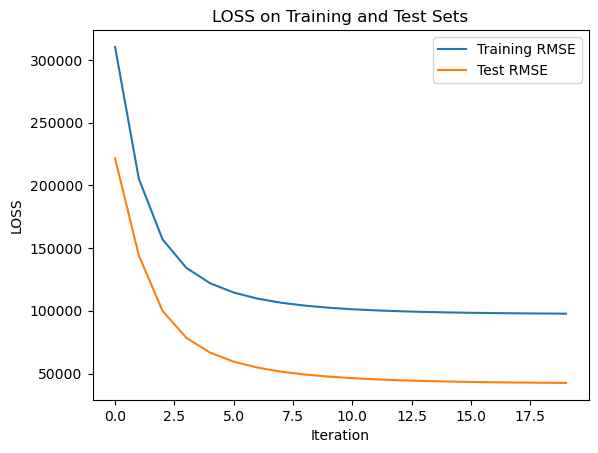

In [69]:
plt.plot(range(num_iterations), losses_training, label='Training RMSE')
plt.plot(range(num_iterations), losses_test, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('LOSS')
plt.title('LOSS on Training and Test Sets')
plt.legend()
plt.savefig('loss_plot_k20.pdf',format='pdf')
plt.show()

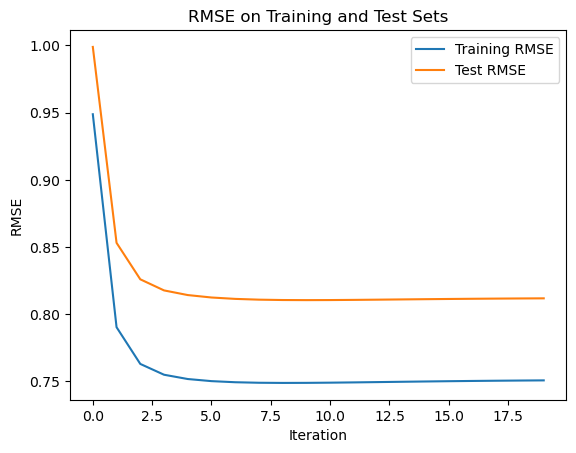

In [70]:
plt.plot(range(num_iterations), rmses_training, label='Training RMSE')
plt.plot(range(num_iterations),  rmses_test, label='Test RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE on Training and Test Sets')
plt.legend()

plt.savefig('RMSE_plot_k20.pdf',format='pdf')
plt.show()

In [108]:
np.save('model_user_biases.npy',user_biases_model)
np.save('model_item_biases.npy',item_biases_model)
np.save('model_user.npy',U_model)
np.save('model_item.npy',V_model)
user_biases_model = np.load("model_user_biases.npy")
item_biases_model = np.load("model_item_biases.npy")
U_model = np.load("model_user.npy")
V_model = np.load("model_item.npy")

In [109]:
#Train the new user
movie_rate =[(4993,5)]#id of moivie, rate of this movie
bias_new = 0
user_new = np.zeros(K)
# for _ in range(5):
for (n, r) in movie_rate:
    n = movie_to_id[n]
    prediction = user_new + item_biases_model[n]
    error = r - prediction
    t1 += V_model[n]*error
    t0 += np.dot(V_model[n].reshape(-1,1), V_model[n].reshape(-1,1).T)
t0 = lambda_*t0 + tau*np.eye(K)
t1 = lambda_*t1
user_new = linalg.solve(term0,term1)